<a href="https://colab.research.google.com/github/FatmaBuseBorlu/DRAMER-Dataset/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from IPython import get_ipython
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import random
from torcheeg.datasets import DREAMERDataset
from torcheeg import transforms
from collections import Counter

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# Veri setinin bulunduğu dizin
dataset_path = "/content/drive/MyDrive/Dramer/Kodlar/DREAMER.mat"

In [34]:
# Veri Artırma: Özel Flip ve Gürültü Ekleme
class CustomRandomFlip:
    def __init__(self, axis):
        self.axis = axis

    def __call__(self, eeg=None, **kwargs):
        if eeg is not None and isinstance(eeg, torch.Tensor):
            if random.random() > 0.5:
                eeg = torch.flip(eeg, dims=(self.axis,))
        return {**kwargs, 'eeg': eeg}

offline_transform = transforms.Compose([
    transforms.BaselineRemoval(),
    transforms.MeanStdNormalize(),
    transforms.To2d(),
    transforms.ToTensor(),
    CustomRandomFlip(axis=2),
    transforms.RandomNoise(std=0.02)
])

# Veri Seti
dataset_path = "/content/drive/MyDrive/Dramer/Kodlar/DREAMER.mat"
dataset_multi_label = DREAMERDataset(
    io_path='./dreamer_multi_label_data',
    mat_path=dataset_path,
    offline_transform=offline_transform,
    label_transform=transforms.Compose([
        transforms.Select(['valence', 'arousal']),
        transforms.Binary(3.0)
    ]),
    chunk_size=128,
    baseline_chunk_size=128,
    num_baseline=61,
    num_worker=4
)

[2024-12-27 01:53:50] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ./dreamer_multi_label_data.
INFO:torcheeg:🔍 | Detected cached processing results, reading cache from ./dreamer_multi_label_data.


In [35]:
# Eğitim ve Test Veri Setleri
data_size_multi = len(dataset_multi_label)
train_size_multi = int(0.8 * data_size_multi)
test_size_multi = data_size_multi - train_size_multi
train_dataset_multi, test_dataset_multi = random_split(dataset_multi_label, [train_size_multi, test_size_multi])

In [36]:
# Veri yükleyiciler
train_loader_multi = DataLoader(train_dataset_multi, batch_size=32, shuffle=True)
test_loader_multi = DataLoader(test_dataset_multi, batch_size=32, shuffle=False)

In [37]:
# Sınıf Ağırlıklarını Hesaplama
def calculate_class_weights(dataset):
    valence_labels = []
    arousal_labels = []

    for _, label in dataset:
        valence_labels.append(label[0])
        arousal_labels.append(label[1])

    valence_counts = Counter(valence_labels)
    arousal_counts = Counter(arousal_labels)

    total_valence = sum(valence_counts.values())
    total_arousal = sum(arousal_counts.values())

    valence_weights = {cls: total_valence / count for cls, count in valence_counts.items()}
    arousal_weights = {cls: total_arousal / count for cls, count in arousal_counts.items()}

    valence_weight_tensor = torch.tensor(
        [valence_weights[cls] for cls in sorted(valence_weights.keys())]
    ).to(device)
    arousal_weight_tensor = torch.tensor(
        [arousal_weights[cls] for cls in sorted(arousal_weights.keys())]
    ).to(device)

    return valence_weight_tensor, arousal_weight_tensor

# Sınıf ağırlıklarını hesapla ve GPU'ya aktar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
valence_weight_tensor, arousal_weight_tensor = calculate_class_weights(train_dataset_multi)
# Kayıp Fonksiyonları
valence_criterion = nn.CrossEntropyLoss(weight=valence_weight_tensor).to(device)
arousal_criterion = nn.CrossEntropyLoss(weight=arousal_weight_tensor).to(device)


In [38]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Model tanımı (Dropout oranını parametre olarak alıyoruz)
class EEG_MultiLabel_Model(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(EEG_MultiLabel_Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.pool = nn.AdaptiveAvgPool2d((4, 4))
        self.dropout = nn.Dropout(dropout_rate)  # Dinamik dropout oranı

        self.fc1 = nn.Linear(256 * 4 * 4, 256)
        self.fc_valence = nn.Linear(256, 2)
        self.fc_arousal = nn.Linear(256, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Dinamik dropout uygulanır

        valence_output = self.fc_valence(x)
        arousal_output = self.fc_arousal(x)
        return valence_output, arousal_output


# Modeli tanımlayın ve optimizer ile scheduler'ı ekleyin
initial_dropout = 0.3  # Başlangıç dropout oranı
model = EEG_MultiLabel_Model(dropout_rate=0.3).to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-5)

In [39]:
# Eğitim Fonksiyonu
def train_multi_label_epoch():
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader_multi:
        inputs = inputs.float().to(device)
        labels = torch.stack(labels, dim=1).long().to(device)
        inputs = inputs.unsqueeze(1) if inputs.dim() == 3 else inputs
        optimizer.zero_grad()
        valence_output, arousal_output = model(inputs)
        loss_valence = valence_criterion(valence_output, labels[:, 0])
        loss_arousal = arousal_criterion(arousal_output, labels[:, 1])
        loss = loss_valence + loss_arousal
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader_multi)

In [40]:
# Test Fonksiyonu
def test_multi_label_model():
    model.eval()
    running_loss, all_valence_preds, all_arousal_preds, all_labels = 0.0, [], [], []
    with torch.no_grad():
        for inputs, labels in test_loader_multi:
            inputs = inputs.float().to(device)
            labels = torch.stack(labels, dim=1).long().to(device)
            inputs = inputs.unsqueeze(1) if inputs.dim() == 3 else inputs
            valence_output, arousal_output = model(inputs)
            loss_valence = valence_criterion(valence_output, labels[:, 0])
            loss_arousal = arousal_criterion(arousal_output, labels[:, 1])
            loss = loss_valence + loss_arousal
            running_loss += loss.item()
            _, valence_preds = torch.max(valence_output, 1)
            _, arousal_preds = torch.max(arousal_output, 1)
            all_valence_preds.extend(valence_preds.cpu().numpy())
            all_arousal_preds.extend(arousal_preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(test_loader_multi)
    valence_accuracy = accuracy_score([l[0] for l in all_labels], all_valence_preds)
    arousal_accuracy = accuracy_score([l[1] for l in all_labels], all_arousal_preds)
    valence_f1 = f1_score([l[0] for l in all_labels], all_valence_preds, average='weighted')
    arousal_f1 = f1_score([l[1] for l in all_labels], all_arousal_preds, average='weighted')

    return avg_loss, valence_accuracy, arousal_accuracy, valence_f1, arousal_f1, all_labels, all_valence_preds, all_arousal_preds

In [41]:
# Eğitim döngüsü
epochs = 10
train_losses = []
test_losses = []
current_dropout = initial_dropout

for epoch in range(epochs):
    # Eğitim
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader_multi:
        inputs = inputs.float().to(device)
        labels = torch.stack(labels, dim=1).long().to(device)
        inputs = inputs.unsqueeze(1) if inputs.dim() == 3 else inputs
        optimizer.zero_grad()
        valence_output, arousal_output = model(inputs)
        loss_valence = valence_criterion(valence_output, labels[:, 0])
        loss_arousal = arousal_criterion(arousal_output, labels[:, 1])
        loss = loss_valence + loss_arousal
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader_multi))

    # Test
    test_loss, valence_acc, arousal_acc, valence_f1, arousal_f1, _, _, _ = test_multi_label_model()
    test_losses.append(test_loss)

    # Cosine Annealing Scheduler'ı güncelle
    scheduler.step()

    # Dropout oranını azalt
    if (epoch + 1) % 10 == 0 and current_dropout > 0.1:  # Her 10 epoch'ta bir azalt
        current_dropout -= 0.05
        model.dropout = nn.Dropout(current_dropout)  # Modelde dropout oranını güncelleyin

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")
    print(f"Valence Accuracy: {valence_acc:.4f}, Arousal Accuracy: {arousal_acc:.4f}")
    print(f"Valence F1 Score: {valence_f1:.4f}, Arousal F1 Score: {arousal_f1:.4f}")

Epoch 1/10, Train Loss: 1.3569, Test Loss: 1.3099
Valence Accuracy: 0.4092, Arousal Accuracy: 0.7469
Valence F1 Score: 0.3002, Arousal F1 Score: 0.7503
Epoch 2/10, Train Loss: 1.3032, Test Loss: 1.2687
Valence Accuracy: 0.5513, Arousal Accuracy: 0.7715
Valence F1 Score: 0.5524, Arousal F1 Score: 0.7706
Epoch 3/10, Train Loss: 1.2389, Test Loss: 1.2106
Valence Accuracy: 0.6381, Arousal Accuracy: 0.6783
Valence F1 Score: 0.6355, Arousal F1 Score: 0.7026
Epoch 4/10, Train Loss: 1.1456, Test Loss: 1.0529
Valence Accuracy: 0.6690, Arousal Accuracy: 0.7464
Valence F1 Score: 0.6731, Arousal F1 Score: 0.7628
Epoch 5/10, Train Loss: 1.0399, Test Loss: 0.9922
Valence Accuracy: 0.6918, Arousal Accuracy: 0.7424
Valence F1 Score: 0.6948, Arousal F1 Score: 0.7605
Epoch 6/10, Train Loss: 0.9453, Test Loss: 0.8987
Valence Accuracy: 0.7230, Arousal Accuracy: 0.7865
Valence F1 Score: 0.7261, Arousal F1 Score: 0.7990
Epoch 7/10, Train Loss: 0.8689, Test Loss: 0.8575
Valence Accuracy: 0.7594, Arousal Accu

Final Valence F1 Score: 0.7944, Final Arousal F1 Score: 0.8334


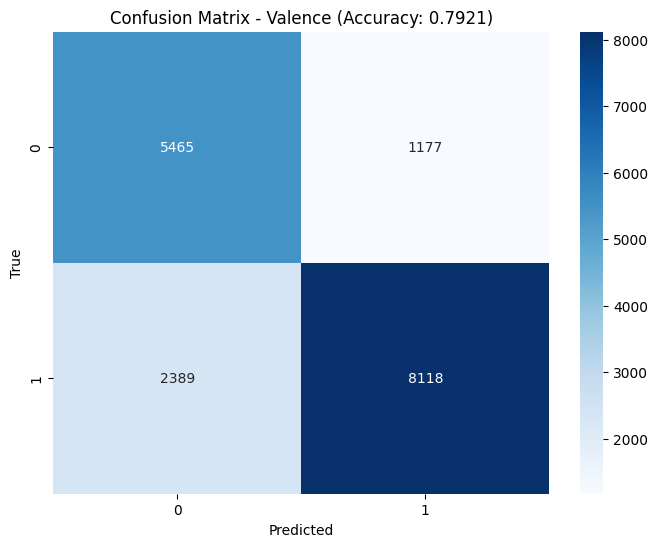

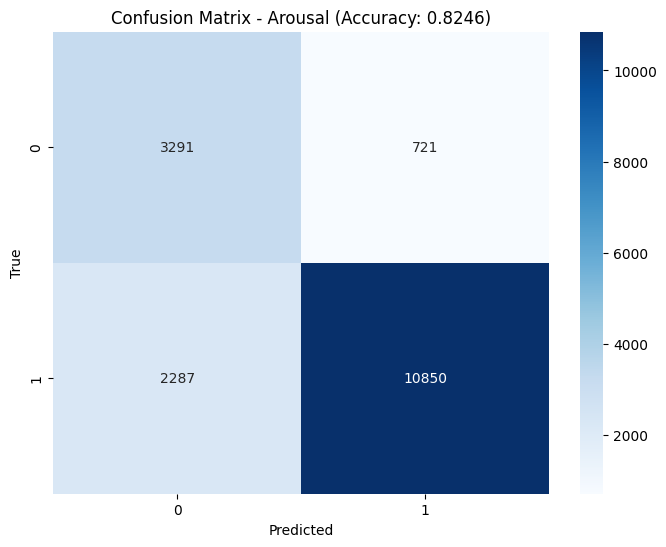

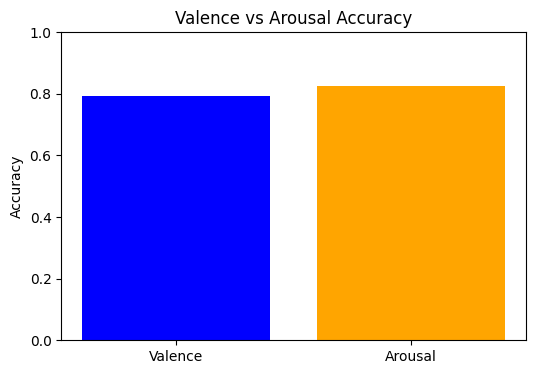

In [42]:
# Sonuçları Görselleştirme
def plot_results(cm_valence, cm_arousal, valence_acc, arousal_acc):
    # Karışıklık Matrisi: Valence
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_valence, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Valence (Accuracy: {valence_acc:.4f})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Karışıklık Matrisi: Arousal
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_arousal, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Arousal (Accuracy: {arousal_acc:.4f})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Doğruluk karşılaştırması
    plt.figure(figsize=(6, 4))
    plt.bar(['Valence', 'Arousal'], [valence_acc, arousal_acc], color=['blue', 'orange'])
    plt.title('Valence vs Arousal Accuracy')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()

# Test ve Görselleştirme
test_loss, valence_acc, arousal_acc, valence_f1, arousal_f1, all_labels, valence_preds, arousal_preds = test_multi_label_model()
cm_valence = confusion_matrix([l[0] for l in all_labels], valence_preds)
cm_arousal = confusion_matrix([l[1] for l in all_labels], arousal_preds)
print(f"Final Valence F1 Score: {valence_f1:.4f}, Final Arousal F1 Score: {arousal_f1:.4f}")
plot_results(cm_valence, cm_arousal, valence_acc, arousal_acc)

Final Test Loss: 0.7794
Final Valence Accuracy: 0.7921, Final Arousal Accuracy: 0.8246
Final Valence F1 Score: 0.7944, Final Arousal F1 Score: 0.8334
Confusion Matrix (Valence):
 [[5465 1177]
 [2389 8118]]
Confusion Matrix (Arousal):
 [[ 3291   721]
 [ 2287 10850]]


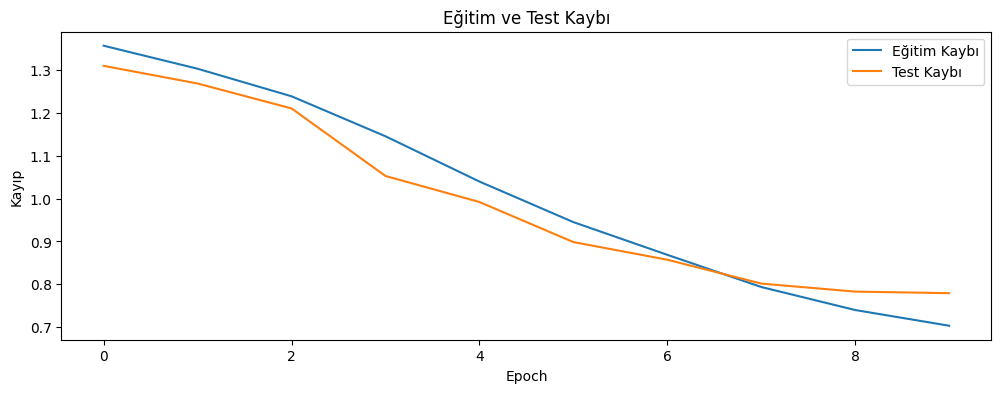

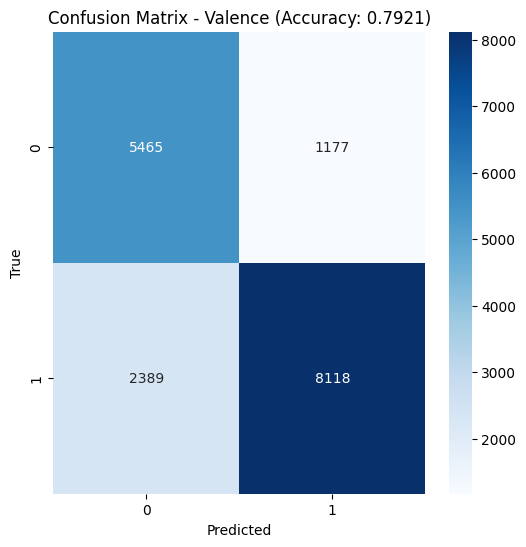

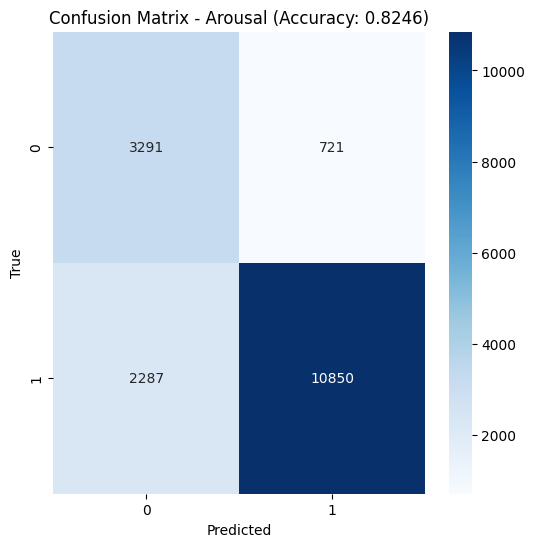

In [43]:
# Sonuçları tekrar test edip raporla
test_loss, valence_acc, arousal_acc, valence_f1, arousal_f1, all_labels, valence_preds, arousal_preds = test_multi_label_model()
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Valence Accuracy: {valence_acc:.4f}, Final Arousal Accuracy: {arousal_acc:.4f}")
print(f"Final Valence F1 Score: {valence_f1:.4f}, Final Arousal F1 Score: {arousal_f1:.4f}")

# Karışıklık Matrisleri
cm_valence = confusion_matrix([l[0] for l in all_labels], valence_preds)
cm_arousal = confusion_matrix([l[1] for l in all_labels], arousal_preds)
print("Confusion Matrix (Valence):\n", cm_valence)
print("Confusion Matrix (Arousal):\n", cm_arousal)

# Görselleştirme Fonksiyonu
def plot_results(train_losses, test_losses, cm_valence, cm_arousal, valence_acc, arousal_acc):
    # Eğitim ve Test Kaybı Grafiği
    plt.figure(figsize=(12, 4))
    plt.plot(train_losses, label='Eğitim Kaybı')
    plt.plot(test_losses, label='Test Kaybı')
    plt.title('Eğitim ve Test Kaybı')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp')
    plt.legend()
    plt.show()

    # Valence Karışıklık Matrisi
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_valence, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Valence (Accuracy: {valence_acc:.4f})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Arousal Karışıklık Matrisi
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_arousal, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Arousal (Accuracy: {arousal_acc:.4f})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

plot_results(train_losses, test_losses, cm_valence, cm_arousal, valence_acc, arousal_acc)